Importing Modules

In [5]:
pip install psycopg2-binary

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/ce/85/62825cabc6aad53104b7b6d12eb2ad74737d268630032d07b74d4444cb72/psycopg2_binary-2.9.9-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 962.2 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
import psycopg2

# pandas module 
import pandas as pd

# pyspark SQL functions 
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from IPython.core.display import display, HTML

/tmp/ipykernel_502/1336244224.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
display(HTML("<style>pre { white-space: pre !important; }</style>"))

Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [91]:
data = spark.read.csv("dataset.csv",inferSchema=True,header=True)
data.show(4)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [92]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension 

In [93]:
data.count()

7043

In [94]:
len(data.columns)

21

In [95]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

Let's get all the numerical features and store them into a pandas dataframe.

In [96]:
numerical_columns = [name for name, typ in data.dtypes if typ == 'int' or typ == 'double']
categorical_columns = [name for name, typ in data.dtypes if typ == 'string']

data.select(categorical_columns).show(10)

+----------+------+-------------+-------+----------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|Churn|
+----------+------+-------------+-------+----------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|          No|No phone service|            DSL|            No|         Yes|              No|         No|         No|             No|Month-to-month|             Yes|    Electronic check|   No|
|5575-GNVDE|  Male|         

In [97]:
df = data.select(numerical_columns).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns. 

/tmp/ipykernel_1844/2107032722.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins =20,ax=ax)


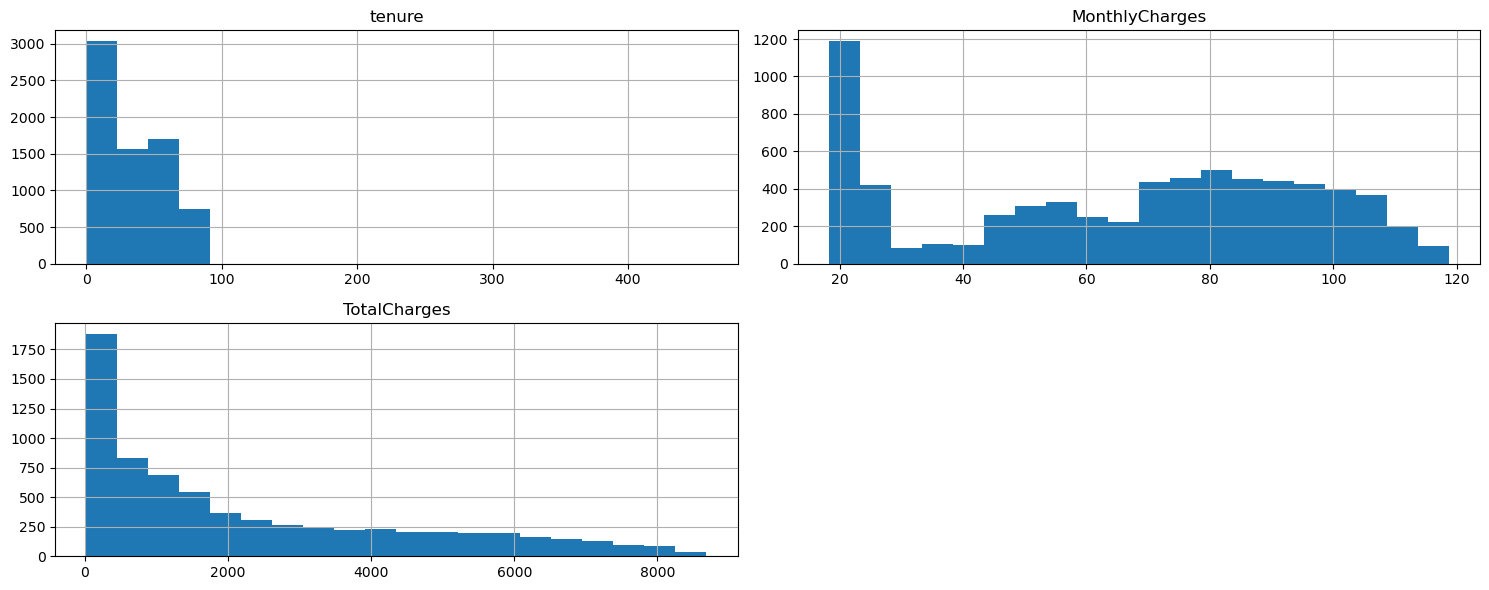

In [98]:
fig = plt.figure(figsize=(15,6))
ax =fig.gca()
df.hist(bins =20,ax=ax)
plt.tight_layout()
plt.show()

Let's generate the correlation matrix 

In [99]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [100]:
for column in categorical_columns:
    data.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [101]:
for column in data.columns:
    data.select(count(when(col(column).isNull(),column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+



Exception ignored in: <function JavaWrapper.__del__ at 0x7fbaa8813880>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'Imputer' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7fbaa8813880>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+-----------+

+---------------+
|StreamingMovies|
+---------------+
|              0|
+---------------+

+--------+
|Contract|
+--------+
|       0|
+--------+

+----------------+
|PaperlessBilling|
+----------------+
|               0|
+----------------+

+-------------+
|PaymentMethod|
+-------------+
|            0|
+-------------+

+--------------+
|MonthlyCharges|
+--------------+
|             0|
+--------------+

+------------+
|TotalCharges|
+------------+
|          11|
+------------+

+-----+
|Churn|
+-----+

In [102]:
missing_col = ['TotalCharges']

In [103]:
imputer = Imputer(inputCols = missing_col , outputCols= missing_col).setStrategy('mean')

In [104]:
imputer = impute.fit(data)

In [105]:
data = imputer.transform(data)
data.select(count(when(col('TotalCharges').isNull(),'TotalCharges')).alias('TotalCharges')).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



In [106]:
data.select("*").where(data.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [107]:
data = data.filter(data.tenure < 100)

In [110]:
numerical_vector_assembler = VectorAssembler(inputCols= numerical_columns, outputCol="numerical_vector_assembled")
data = numerical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_vector_assembled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone serv

In [111]:
scaler = StandardScaler(inputCol= "numerical_vector_assembled", outputCol="numerical_vector_scaled", withStd=True, withMean=True)
data = scaler.fit(data).transform(data)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_vector_assembled|numerical_vector_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+
|7590-VHVEG|F

In [118]:
categorical_columns_indexed = [ name + "_indexed" for name in categorical_columns]
indexer = StringIndexer(inputCols=categorical_columns,outputCols= categorical_columns_indexed)
data = indexer.fit(data).transform(data)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_vector_assemble

Let's combine all of our categorifal features in to one feature vector.

In [119]:
categorical_columns_indexed.remove('customerID_indexed')
categorical_columns_indexed.remove('Churn_indexed')


categorical_vector_assembler = VectorAssembler(inputCols= categorical_columns_indexed, outputCol="categorical_features_assembled")
data = categorical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+------------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|

Now let's combine categorical and numerical feature vectors.

In [120]:
scaler = StandardScaler(inputCol= "categorical_features_assembled", outputCol="categorical_features_scaled", withStd=True, withMean=True)
data = scaler.fit(data).transform(data)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+------------------------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|

In [127]:
final_vector_assembler = VectorAssembler(inputCols=['categorical_features_scaled','numerical_vector_scaled'], outputCol= 'final_feature_vectored')
data = final_vector_assembler.transform(data)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+------------------------------+---------------------------+----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|

In [128]:
train ,test = data.randomSplit([0.7,0.3], seed = 0)

In [129]:
print(train.count())
print(test.count())

4899
2143


Now let's create and train our desicion tree

In [130]:
dt = DecisionTreeClassifier(featuresCol= "final_feature_vectored" , labelCol= 'Churn_indexed')

In [131]:
model = dt.fit(train)

Let's make predictions on our test data

In [132]:
test_pred = model.transform(test)
test_pred.select(['churn','prediction']).show()

+-----+----------+
|churn|prediction|
+-----+----------+
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



In [136]:
evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
auc_test = evaluator.evaluate(test_pred)
auc_test

0.592959423205902

Let's get the AUC for our `training` set

In [137]:
predictions_train = model.transform(train)
auc_train = evaluator.evaluate(predictions_train)
auc_train

0.6215340190275663

In [147]:
train.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+------------------------------+---------------------------+----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBillin

In [148]:
test.show(10)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-----------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+------------------------------+---------------------------+----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|      

**Hyper parameter tuning** 

In [149]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vectored', labelCol ='Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [150]:
max_depth = [5,10,15,20]
test_accs  , train_accs = evaluate_dt(max_depth)
print(train_accs)
print(test_accs)

[0.6215340190275663, 0.6958349480174955, 0.968126668714663, 0.9897510103614657]
[0.592959423205902, 0.6175883076235189, 0.7042342946568299, 0.682251285490722]


Let's visualize our results

<Axes: xlabel='max_depth', ylabel='train_accs'>

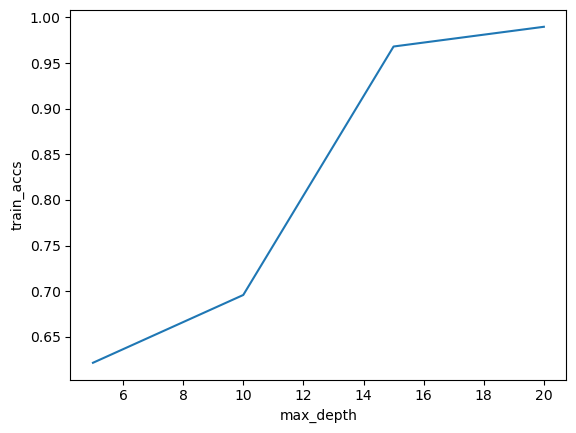

In [165]:
df = pd.DataFrame()

df['max_depth'] = max_depth
df['train_accs'] = train_accs
df['test_accs'] = test_accs


sns.lineplot(df , x="max_depth" , y='train_accs')

<Axes: xlabel='max_depth', ylabel='test_accs'>

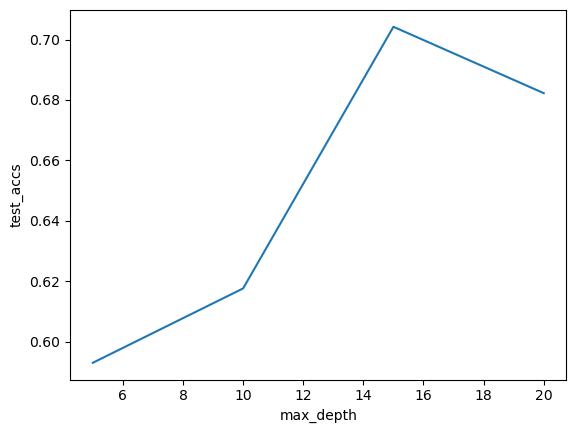

In [166]:
sns.lineplot(df , x="max_depth" , y='test_accs')